<h1><b> Welcome to Object detection from scratch

In [2]:
# necessary only if you are training your model on colab and want to save checkpoints to your gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2><b> Necessary downloads

In [3]:
# get the animals data
!gdown --id 1ZYwdQbYC_vfS255F1seJwWpfA8dfU-j5

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZYwdQbYC_vfS255F1seJwWpfA8dfU-j5
To: /content/animals.zip
100% 39.9k/39.9k [00:00<00:00, 53.5MB/s]


In [4]:
# unzip and store in folder
!unzip animals.zip

Archive:  animals.zip
   creating: animals/
  inflating: animals/dog.png         
  inflating: __MACOSX/animals/._dog.png  
  inflating: animals/rabbit.png      
  inflating: __MACOSX/animals/._rabbit.png  
  inflating: animals/turtle.png      
  inflating: __MACOSX/animals/._turtle.png  
  inflating: animals/.DS_Store       
  inflating: __MACOSX/animals/._.DS_Store  
  inflating: animals/elephant.png    
  inflating: __MACOSX/animals/._elephant.png  
  inflating: animals/rat.png         
  inflating: __MACOSX/animals/._rat.png  
  inflating: animals/octopus.png     
  inflating: __MACOSX/animals/._octopus.png  
  inflating: animals/tiger.png       
  inflating: __MACOSX/animals/._tiger.png  
  inflating: animals/cow.png         
  inflating: __MACOSX/animals/._cow.png  
  inflating: animals/cheetah.png     
  inflating: __MACOSX/animals/._cheetah.png  
  inflating: animals/penguin.png     
  inflating: __MACOSX/animals/._penguin.png  
  inflating: animals/cat.png         
  inflating

In [5]:
# get the backgrounds data
!gdown --id 1_6cYCg9xLES0r65DcYeLV3V__wVy7JeV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_6cYCg9xLES0r65DcYeLV3V__wVy7JeV
To: /content/backgrounds_320x320.zip
100% 2.08M/2.08M [00:00<00:00, 212MB/s]


In [6]:
# unzip and store
!unzip backgrounds_320x320.zip

Archive:  backgrounds_320x320.zip
   creating: backgrounds_320x320/
  inflating: backgrounds_320x320/image_1.jpg  
  inflating: backgrounds_320x320/image_10.jpg  
  inflating: backgrounds_320x320/image_11.jpg  
  inflating: backgrounds_320x320/image_12.jpg  
  inflating: backgrounds_320x320/image_13.jpg  
  inflating: backgrounds_320x320/image_14.jpg  
  inflating: backgrounds_320x320/image_15.jpg  
  inflating: backgrounds_320x320/image_16.jpg  
  inflating: backgrounds_320x320/image_17.jpg  
  inflating: backgrounds_320x320/image_18.jpg  
  inflating: backgrounds_320x320/image_19.jpg  
  inflating: backgrounds_320x320/image_2.jpg  
  inflating: backgrounds_320x320/image_20.jpg  
  inflating: backgrounds_320x320/image_21.jpg  
  inflating: backgrounds_320x320/image_22.jpg  
  inflating: backgrounds_320x320/image_23.jpg  
  inflating: backgrounds_320x320/image_24.jpg  
  inflating: backgrounds_320x320/image_25.jpg  
  inflating: backgrounds_320x320/image_3.jpg  
  inflating: background

In [8]:
# move the fonts file to main directory
""" 
  Important STEP. must be done to avoid errors 
"""
%mv '/content/backgrounds_320x320/Type Machine.ttf' '/content'

In [277]:
# get trained weights

!gdown --id 1Eibp-Sedvc4xdAhs3n88R4o1kAwjP-M7

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Eibp-Sedvc4xdAhs3n88R4o1kAwjP-M7
To: /content/final_weights_customOD.zip
100% 27.3M/27.3M [00:00<00:00, 247MB/s]


In [276]:
# unzip and store
!unzip final_weights_customOD.zip

Archive:  final_weights_customOD.zip
  inflating: weights291022/checkpoint  
  inflating: weights291022/epoch_latest.model.index  
  inflating: weights291022/epoch_latest.model.data-00000-of-00001  


<h2><b> Necessary imports

In [162]:
# Import required libraries. TF version used is 2.9.2

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
import cv2
import random


from PIL import Image, ImageDraw
from PIL import ImageFont
from IPython.display import Image as displayImage

font = ImageFont.truetype("Type Machine.ttf", 10)

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, Concatenate, Reshape
import keras.losses

# from tensorflow.keras.layers.core import Reshape

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

tf.config.run_functions_eagerly(True) 

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


In [10]:
np.set_printoptions(threshold=np.inf) # increase print threshold to infinity to view full numpy outputs

<h2><b>Core functions for Object detection

In [11]:
"""
Generates anchor boxes for a given image size, size of anchors
and ratios of anchors
"""

def multibox_prior(X, sizes, ratios):
    in_height, in_width = X.shape[-3:-1]
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = tf.convert_to_tensor(sizes)
    ratio_tensor = tf.convert_to_tensor(ratios)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis
    # print("steps_h, steps_w", steps_h, steps_w)

    # Generate all center points for the anchor boxes
    center_h = (tf.range(in_height, dtype=tf.float32) + offset_h) * steps_h
    center_w = (tf.range(in_width, dtype=tf.float32) + offset_w) * steps_w
    shift_y, shift_x = tf.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # print("center_h, center_w", center_h, center_w)
    # print("shift_y, shift_x", shift_y, shift_x)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = tf.concat((size_tensor * tf.sqrt(ratio_tensor[0]), sizes[0] * tf.sqrt(ratio_tensor[1:])), axis=0) * in_height / in_width  # Handle rectangular inputs
    h = tf.concat((size_tensor / tf.sqrt(ratio_tensor[0]), sizes[0] / tf.sqrt(ratio_tensor[1:])), axis=0)
    # print(w, h)
    # Divide by 2 to get half height and half width
    # print(type(tf.stack((-w, -h, w, h)).T.numpy()))
    # return
    anchor_manipulations = np.tile(tf.stack((-w, -h, w, h), axis=0).numpy(), in_height * in_width) / 2
    anchor_manipulations = anchor_manipulations.T
    # print('anchor_manipulations: ', anchor_manipulations.shape)
    # print(anchor_manipulations)
    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    # print('outgrid: ', tf.stack([shift_x, shift_y, shift_x, shift_y], axis=1).numpy().repeat(boxes_per_pixel, 0))
    out_grid = tf.stack([shift_x, shift_y, shift_x, shift_y], axis=1).numpy().repeat(boxes_per_pixel, 0)
    output = out_grid + anchor_manipulations
    print('output: ', output.shape)
    # print(output)
    return tf.expand_dims(output, 0)

In [12]:
"""
Computes IoU of one list of boxes over other
box format: np.array([[xmin, ymin, xmax, ymax], ...])
returns ious of size [len(boxes1), len(boxes2)]
"""
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # print('curr area: ', areas1, '\n')
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = tf.math.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = tf.math.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).numpy().clip(min=0)
    # print(inters)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [13]:
"""
Compute if a new object in an Image is overlapping with alraedy existing object's boxes.
"""

def overlap(boxes1, boxes2):
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))

    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    inter_upperlefts = tf.math.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = tf.math.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).numpy().clip(min=0)

    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
 
    if np.where(((inter_areas / union_areas) * areas1)[0] > 0.01)[0].shape[0] > 0:
        return True
   

    return False

In [15]:
"""
Assign closest ground-truth bounding boxes to anchor boxes.
One or more than one overlapping anchor boxes are assigned to each bounding boxes depending 
upon the given iou_threshhold 
"""

def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.4):
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # print('jaccard: ', jaccard)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = tf.fill((num_anchors,), -1)
    # print('anchors_bbox_map: ', anchors_bbox_map)
    # Assign ground-truth bounding boxes according to the threshold
    # print(tf.math.reduce_max(jaccard, axis=1))
    
    max_ious = tf.math.reduce_max(jaccard, axis=1)
    indices = tf.math.argmax(jaccard, axis=1)
    # print('max_ious, indices: ', max_ious, indices)
    anc_i = tf.where(max_ious >= iou_threshold).reshape(-1)
    # print('anc_i: ', anc_i)
    box_j = indices[max_ious >= iou_threshold]
    # print('box_j: ', box_j)
    anchors_bbox_map_np = np.array(anchors_bbox_map)
    anchors_bbox_map_np[np.array(anc_i[:])] = box_j
    # print('anchors_bbox_map: ', anchors_bbox_map_np)
    col_discard = tf.fill((num_anchors,), -1)
    row_discard = tf.fill((num_gt_boxes,), -1)
    # print('row_discard, col_discard: ', row_discard, col_discard)
    jaccard = np.array(jaccard)
    for i in range(num_gt_boxes):
        max_idx = tf.math.argmax(jaccard[:, i])  # Find the largest IoU
        # print('max_idx: ', max_idx)
        box_idx = i
        anc_idx = max_idx
        # print('box_idx, anc_idx: ', box_idx, anc_idx)
        anchors_bbox_map_np[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    # print('jaccard: ', jaccard)
    return tf.convert_to_tensor(anchors_bbox_map_np)

In [16]:
"""
Converts bounding box from (xmin, ymin, xmax, ymax) format
to (cx, cy, width, height) format
"""

def box_corner_to_center(cords):
    try:
        ret = cords.numpy()
    except:
        ret = np.copy(cords)
    ret[:, 0] = cords[:, 0] + (cords[:, 2] - cords[:, 0]) / 2
    ret[:, 1] = cords[:, 1] + (cords[:, 3] - cords[:, 1]) / 2
    ret[:, 2] = cords[:, 2] - cords[:, 0]
    ret[:, 3] = cords[:, 3] - cords[:, 1]
    return tf.convert_to_tensor(ret)

In [17]:
"""
Converts bounding box from (cx, cy, width, height) format
to (xmin, ymin, xmax, ymax) format
"""

def box_center_to_corner(cords):
    try:
        ret = cords.numpy()
    except:
        ret = np.copy(cords)
    ret[:, 0] = cords[:, 0] - cords[:, 2] / 2
    ret[:, 1] = cords[:, 1] - cords[:, 3] / 2
    ret[:, 2] = cords[:, 2] + ret[:, 0]
    ret[:, 3] = cords[:, 3] + ret[:, 1]
    return tf.convert_to_tensor(ret)

In [18]:
"""
Calculates offsets of actual bounding boxes from predefined anchors
"""

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    # print("offset_boxes", anchors.shape, assigned_bb.shape)
    # print(assigned_bb, assigned_bb)
    """Transform for anchor box offsets."""
    # change anchors to yolo form (cx, cy, width, height)
    c_anc = box_corner_to_center(anchors)
    # print('c_anc: ', c_anc)
    # change bbox to yolo form (cx, cy, width, height)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    # print('c_assigned_bb: ', c_assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * tf.math.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = tf.concat([offset_xy, offset_wh], axis=1)
    return offset

In [19]:
"""
One of the most important function/step for Object detection

Input: 
1. pre generated anchors boxes
2. the class labels from training input
3. the bounding box labels from training input

The following things takes place in this function:
---------------------------------------------------

for each batch of input,
1.  a anchors_bbox_map is created of size 2140 which tells that out of 2140 anchor boxes
    which are those anchor boxes active or overlaps with input labels

2.  bbox_mask of shape 8560 is created which copies over the active anchors_box_map 
    4 times to match with output bounding boxes of shape (batch_size, 8560)
    It has values 0 or 1 which signifies active or inactive

3.  new class_labels and assigned_bb (bounding box) are created initialized as 
    empty arrays of shape(2140, 16) and (2140, 4) respectively

4.  these new labels and bb are fed with values from input labels with respect to
    anchors indexes (print and see yourself for in depth clarification)

5.  offsets are created for the new bb with respect to prdefined anchors. During training, inference
    those are offsets what are predicted by the model, they go through offset_inverse
    for plotting and iou calculations 


At the end after completeng all steps for every batch the new bbox_offset, bbox_masks,
class_labels ( initialised as one hot encoded class for active anchors and one hot encoded background 
for background anchors ), all these values are returned to caller function (loss function for
loss calculation)

"""

def multibox_target(anchors, cls_labels, box_labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors, n_classes = len(cls_labels), anchors[0], cls_labels.shape[-1]
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    for i in range(batch_size):
        label = box_labels[i]
        c_label = cls_labels[i]
        # print('c_label: ', c_label)
        anchors_bbox_map = assign_anchor_to_bbox(label, anchors)
        # print('anchors_bbox_map: ', anchors_bbox_map)
        bbox_mask = (anchors_bbox_map >= 0).numpy().repeat(4, 0).reshape(-1, 4).astype('float16')
        # print('bbox_mask: ', bbox_mask)

        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = np.zeros((num_anchors, 16))

        # make sure to mark the last column as 1 by default so that it signifies 
        #background class
        class_labels[:, 15] = np.ones(num_anchors)
        # print(class_labels[:, 15])

        assigned_bb = np.zeros((num_anchors, 4))
        # print('class_labels, assigned_bb: ', class_labels, assigned_bb)

        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains one)
        indices_true = tf.where(anchors_bbox_map >= 0).numpy()
        # print('indices_true: ', indices_true)
        bb_idx = np.array(anchors_bbox_map[indices_true])
        # print('bb_idx: ', bb_idx)
 
        # print(bb_idx.shape, indices_true.shape)
        # print(class_labels.shape, cls_labels[bb_idx[:, 0]].shape)
        
        class_labels[indices_true] = c_label[bb_idx] #np.argmax(class_labels[i][bb_idx]) + 1 #label[bb_idx, 0] + 1 
        class_labels[indices_true, 15] = 0
        # assigned_bb = assigned_bb.numpy()
       
        assigned_bb[indices_true] = label[bb_idx]
        
        # print('class_labels, assigned_bb after: ', class_labels, assigned_bb)
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        # print('offset: ', offset)
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = tf.stack(batch_offset)
    bbox_mask = tf.stack(batch_mask)
    class_labels = tf.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [20]:
"""
Converts offsets back to actual bounding boxes of form (xmin, ymin, xmax, ymax)
with respect to predefined anchors
"""

def offset_inverse(anchors, offset_preds):
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = tf.math.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = tf.concat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

In [21]:
"""
Major function

Creates anchors boxes for our model.
For our model we need anchors boxes of size
"""

def create_anchors():
    
    sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
    input_shapes = [[20, 20, 3], [10, 10, 3], [5, 5, 3], [3, 3, 3], [1, 1, 3]]
    ratios = [0.5, 1, 2]
    output_anchors = multibox_prior(np.zeros(input_shapes[0]), sizes=sizes[0], ratios=ratios)
    
    for i in range(1,5):
        anchors_t = multibox_prior(np.zeros(input_shapes[i]), sizes=[0.75, 0.5], ratios=[1, 2, 0.5])
        output_anchors = tf.concat([output_anchors, anchors_t], axis=1)
        
    return output_anchors  

In [22]:
anchors = create_anchors()
anchors.shape

output:  (1600, 4)
output:  (400, 4)
output:  (100, 4)
output:  (36, 4)
output:  (4, 4)


TensorShape([1, 2140, 4])

<h2><b>Understanding anchors

simple and precise explanation: https://www.youtube.com/watch?v=5sYK0z--lqU

In [270]:
# creating 2x2 anchors for demonstrartion (choose different values for better understanding)
# play with sizes and ratios for better understanding

anchors_test = multibox_prior(np.zeros([2,2,3]), sizes=[0.2, 0.272], ratios=[0.5, 1, 2])
anchors_test

output:  (16, 4)


<tf.Tensor: shape=(1, 16, 4), dtype=float32, numpy=
array([[[0.17928931, 0.10857864, 0.3207107 , 0.39142138],
        [0.15383348, 0.05766694, 0.34616652, 0.44233304],
        [0.15      , 0.15      , 0.35      , 0.35      ],
        [0.10857864, 0.17928931, 0.39142138, 0.3207107 ],
        [0.67928934, 0.10857864, 0.82071066, 0.39142138],
        [0.65383345, 0.05766694, 0.84616655, 0.44233304],
        [0.65      , 0.15      , 0.85      , 0.35      ],
        [0.6085786 , 0.17928931, 0.8914214 , 0.3207107 ],
        [0.17928931, 0.6085786 , 0.3207107 , 0.8914214 ],
        [0.15383348, 0.55766696, 0.34616652, 0.94233304],
        [0.15      , 0.65      , 0.35      , 0.85      ],
        [0.10857864, 0.67928934, 0.39142138, 0.82071066],
        [0.67928934, 0.6085786 , 0.82071066, 0.8914214 ],
        [0.65383345, 0.55766696, 0.84616655, 0.94233304],
        [0.65      , 0.65      , 0.85      , 0.85      ],
        [0.6085786 , 0.67928934, 0.8914214 , 0.82071066]]], dtype=float32)>

In [271]:
image = Image.new("RGB", (100, 100), (255, 255, 255))
draw = ImageDraw.Draw(image)

In [272]:
anchors_test = anchors_test * 100
anchors_test

<tf.Tensor: shape=(1, 16, 4), dtype=float32, numpy=
array([[[17.92893  , 10.857863 , 32.071068 , 39.14214  ],
        [15.3833475,  5.766694 , 34.616653 , 44.233303 ],
        [15.000001 , 15.000001 , 35.       , 35.       ],
        [10.857863 , 17.92893  , 39.14214  , 32.071068 ],
        [67.92893  , 10.857863 , 82.07107  , 39.14214  ],
        [65.38335  ,  5.766694 , 84.61665  , 44.233303 ],
        [65.       , 15.000001 , 85.       , 35.       ],
        [60.85786  , 17.92893  , 89.142136 , 32.071068 ],
        [17.92893  , 60.85786  , 32.071068 , 89.142136 ],
        [15.3833475, 55.766697 , 34.616653 , 94.23331  ],
        [15.000001 , 65.       , 35.       , 85.       ],
        [10.857863 , 67.92893  , 39.14214  , 82.07107  ],
        [67.92893  , 60.85786  , 82.07107  , 89.142136 ],
        [65.38335  , 55.766697 , 84.61665  , 94.23331  ],
        [65.       , 65.       , 85.       , 85.       ],
        [60.85786  , 67.92893  , 89.142136 , 82.07107  ]]], dtype=float32)>

In [273]:
colors = ['red', 'blue', 'green', 'magenta']

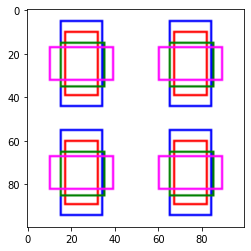

In [274]:
for i in range(anchors_test.numpy().shape[1]):
  draw.rectangle(anchors_test.numpy()[0][i], outline=colors[i%4], width=1)
  plt.imshow(image)

<h2><b>Data Generator implementation

In [23]:
"""
default size of the png images is 72x72
and below are the bounding boxes of animals inside image at this scale
"""

# animals_boxes = {
#     'cat': [3, 68, 14, 57],
#     'cheetah': [0, 70, 20, 57],
#     'cock': [10, 61, 10, 62],
#     'cow': [4, 66, 19, 58],
#     'dog': [4, 64, 11, 63],
#     'elephant': [3, 67, 15, 59],
#     'fish': [11, 65, 15, 61],
#     'goat': [4, 65, 11, 64],
#     'monkey': [6, 66, 8, 63],
#     'octopus': [7, 65, 9, 59],
#     'penguin': [12, 60, 4, 64],
#     'rabbit': [7, 64, 9, 58],
#     'rat': [4, 68, 20, 63],
#     'tiger': [3, 68, 22, 57],
#     'turtle': [4, 67, 14, 57]
# }

In [24]:
# for key in animals_boxes.keys():
#     animals_boxes[key] = np.array(animals_boxes[key])/72

In [25]:
# animals_boxes

In [26]:
# animals = {}
# filenames = fnmatch.filter(os.listdir('animals'), '*.png')

# for idx, filename in enumerate(filenames):
#     temp = {}  
#     temp['name'] = filename.split('.')[0]
#     temp['file'] = filename 
#     temp['boxes'] = animals_boxes[filename.split('.')[0]]
#     animals[idx] = temp

In [27]:
# dictionary of animals with scaled bounding boxes 0 to 1

animals = {
    0: {'name': 'octopus',
      'file': 'octopus.png',
      'boxes': [0.09722222, 0.90277778, 0.125     , 0.81944444]},
     1: {'name': 'cat',
      'file': 'cat.png',
      'boxes': [0.04166667, 0.94444444, 0.19444444, 0.79166667]},
     2: {'name': 'cow',
      'file': 'cow.png',
      'boxes': [0.05555556, 0.91666667, 0.26388889, 0.80555556]},
     3: {'name': 'tiger',
      'file': 'tiger.png',
      'boxes': [0.04166667, 0.94444444, 0.30555556, 0.79166667]},
     4: {'name': 'cock',
      'file': 'cock.png',
      'boxes': [0.13888889, 0.84722222, 0.13888889, 0.86111111]},
     5: {'name': 'turtle',
      'file': 'turtle.png',
      'boxes': [0.05555556, 0.93055556, 0.19444444, 0.79166667]},
     6: {'name': 'monkey',
      'file': 'monkey.png',
      'boxes': [0.08333333, 0.91666667, 0.11111111, 0.875     ]},
     7: {'name': 'rat',
      'file': 'rat.png',
      'boxes': [0.05555556, 0.94444444, 0.27777778, 0.875     ]},
     8: {'name': 'elephant',
      'file': 'elephant.png',
      'boxes': [0.04166667, 0.93055556, 0.20833333, 0.81944444]},
     9: {'name': 'goat',
      'file': 'goat.png',
      'boxes': [0.05555556, 0.90277778, 0.15277778, 0.88888889]},
     10: {'name': 'dog',
      'file': 'dog.png',
      'boxes': [0.05555556, 0.88888889, 0.15277778, 0.875     ]},
     11: {'name': 'rabbit',
      'file': 'rabbit.png',
      'boxes': [0.09722222, 0.88888889, 0.125     , 0.80555556]},
     12: {'name': 'cheetah',
      'file': 'cheetah.png',
      'boxes': [0.        , 0.97222222, 0.27777778, 0.79166667]},
     13: {'name': 'fish',
      'file': 'fish.png',
      'boxes': [0.15277778, 0.90277778, 0.20833333, 0.84722222]},
     14: {'name': 'penguin',
      'file': 'penguin.png',
      'boxes': [0.16666667, 0.83333333, 0.05555556, 0.88888889]}
}

In [28]:
backgrounds = {}
filenames = fnmatch.filter(os.listdir('backgrounds_320x320'), '*.jpg')

for idx, filename in enumerate(filenames):
    temp = {}  
    temp['name'] = filename.split('.')[0]
    temp['file'] = filename 
    backgrounds[idx] = temp

In [29]:
# 25 background images for synthetic random backgrounds
backgrounds

{0: {'name': 'image_23', 'file': 'image_23.jpg'},
 1: {'name': 'image_24', 'file': 'image_24.jpg'},
 2: {'name': 'image_25', 'file': 'image_25.jpg'},
 3: {'name': 'image_9', 'file': 'image_9.jpg'},
 4: {'name': 'image_14', 'file': 'image_14.jpg'},
 5: {'name': 'image_5', 'file': 'image_5.jpg'},
 6: {'name': 'image_19', 'file': 'image_19.jpg'},
 7: {'name': 'image_2', 'file': 'image_2.jpg'},
 8: {'name': 'image_21', 'file': 'image_21.jpg'},
 9: {'name': 'image_1', 'file': 'image_1.jpg'},
 10: {'name': 'image_13', 'file': 'image_13.jpg'},
 11: {'name': 'image_8', 'file': 'image_8.jpg'},
 12: {'name': 'image_20', 'file': 'image_20.jpg'},
 13: {'name': 'image_10', 'file': 'image_10.jpg'},
 14: {'name': 'image_18', 'file': 'image_18.jpg'},
 15: {'name': 'image_16', 'file': 'image_16.jpg'},
 16: {'name': 'image_17', 'file': 'image_17.jpg'},
 17: {'name': 'image_6', 'file': 'image_6.jpg'},
 18: {'name': 'image_7', 'file': 'image_7.jpg'},
 19: {'name': 'image_11', 'file': 'image_11.jpg'},
 20:

In [30]:
# The total number of classes we have
N_CLASSES = len(animals) + 1 # one extra for background

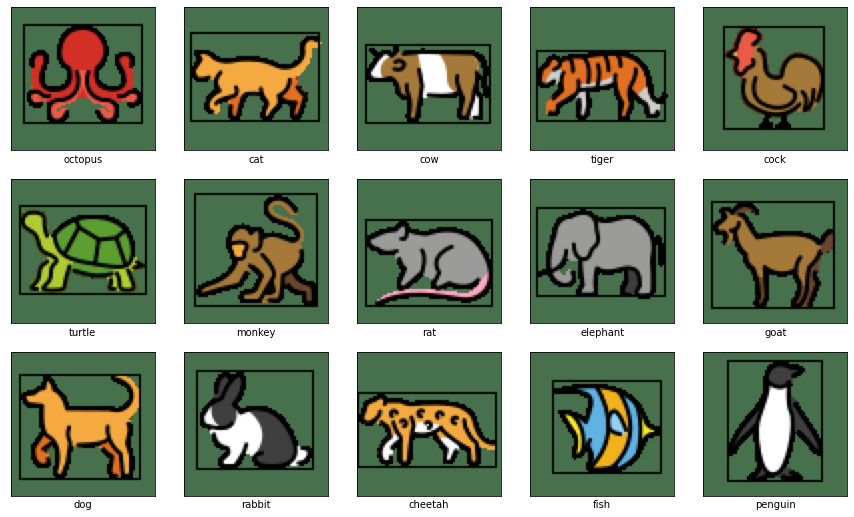

In [31]:
plt.figure(figsize=(N_CLASSES - 1, 9))

for i, (j, e) in enumerate(animals.items()):
    plt.subplot(3, 5, i + 1)
    image = cv2.imread(os.path.join('animals', e['file']))
    image = Image.fromarray(image[:,:,::-1])
    draw = ImageDraw.Draw(image)
    anml = animals[i]
    draw.rectangle((anml['boxes'][0] * 72, anml['boxes'][2]*72, anml['boxes'][1]*72, anml['boxes'][3]*72), outline='black', width=1)
    plt.imshow(image)
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show() # all objects with their bounding boxes visualized

In [32]:
# storing image with the animals dictionary for easy image access
for class_id, values in animals.items():
    png_file = Image.open(os.path.join('animals', values['file'])).convert('RGBA')
    animals[class_id]['image'] = png_file

In [33]:
animals

{0: {'name': 'octopus',
  'file': 'octopus.png',
  'boxes': [0.09722222, 0.90277778, 0.125, 0.81944444],
  'image': <PIL.Image.Image image mode=RGBA size=72x72 at 0x7F10100EA1D0>},
 1: {'name': 'cat',
  'file': 'cat.png',
  'boxes': [0.04166667, 0.94444444, 0.19444444, 0.79166667],
  'image': <PIL.Image.Image image mode=RGBA size=72x72 at 0x7F101090BBD0>},
 2: {'name': 'cow',
  'file': 'cow.png',
  'boxes': [0.05555556, 0.91666667, 0.26388889, 0.80555556],
  'image': <PIL.Image.Image image mode=RGBA size=72x72 at 0x7F10100B3710>},
 3: {'name': 'tiger',
  'file': 'tiger.png',
  'boxes': [0.04166667, 0.94444444, 0.30555556, 0.79166667],
  'image': <PIL.Image.Image image mode=RGBA size=72x72 at 0x7F101090BE90>},
 4: {'name': 'cock',
  'file': 'cock.png',
  'boxes': [0.13888889, 0.84722222, 0.13888889, 0.86111111],
  'image': <PIL.Image.Image image mode=RGBA size=72x72 at 0x7F10100BC250>},
 5: {'name': 'turtle',
  'file': 'turtle.png',
  'boxes': [0.05555556, 0.93055556, 0.19444444, 0.7916

In [34]:
# same goes for backgrounds
for img_id, values in backgrounds.items():
    image = Image.open(os.path.join('backgrounds_320x320', values['file'])).convert('RGB')
    backgrounds[img_id]['image'] = image

In [35]:
backgrounds

{0: {'name': 'image_23',
  'file': 'image_23.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F10100EA4D0>},
 1: {'name': 'image_24',
  'file': 'image_24.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F1010055E90>},
 2: {'name': 'image_25',
  'file': 'image_25.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F101CCCAC90>},
 3: {'name': 'image_9',
  'file': 'image_9.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F1010058650>},
 4: {'name': 'image_14',
  'file': 'image_14.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F10100586D0>},
 5: {'name': 'image_5',
  'file': 'image_5.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F10100587D0>},
 6: {'name': 'image_19',
  'file': 'image_19.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 0x7F1010058750>},
 7: {'name': 'image_2',
  'file': 'image_2.jpg',
  'image': <PIL.Image.Image image mode=RGB size=320x320 at 

In [36]:
# generate random cordinates with random size given a class id
def get_random_cords(class_id):
    size = np.random.randint(50, 160)
    animal_image = animals[class_id]['image'].resize((size, size), Image.LANCZOS)
    row = np.random.randint(0, 320-size)
    col = np.random.randint(0, 320-size)

    xmin = col+(animals[class_id]['boxes'][0]*size)
    xmax = col+(animals[class_id]['boxes'][1]*size)
    ymin = row+(animals[class_id]['boxes'][2]*size)
    ymax = row+(animals[class_id]['boxes'][3]*size)
    return [xmin/320, ymin/320, xmax/320, ymax/320], row, col, animal_image

In [37]:
"""
Creates an image with n number of objects in the image
and returns the generated image along with one hot encoded class array and bbox array
"""
def create_example(n=4):
    # image = Image.new("RGB", (320, 320), (255, 255, 255))
    image = backgrounds[np.random.randint(0, 25)]['image'].copy()
    # n_objects = np.random.randint(1, 5)
    n_objects = n
    class_ids = []
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    cords = []
    
    for _ in range(n_objects):
        
        class_id = np.random.randint(0, N_CLASSES-1)
        new_cord, row, col, animal_image = get_random_cords(class_id)
        
        # print(animals[class_id]['name'])
        if(len(cords) > 0):
            pasted = False
            while not pasted:
                if not overlap(np.array(new_cord).reshape(1, 4), np.array(cords)):
                    pasted = True
                else:
                    new_cord, row, col, animal_image = get_random_cords(class_id)

        image.paste(animal_image, (col, row), mask=animal_image.split()[3])
        
        one_hot_class = [0 for x in range(N_CLASSES)]
        one_hot_class[class_id] = 1
        class_ids.append(one_hot_class)
        
        cords.append(new_cord)
    return image, class_ids, cords


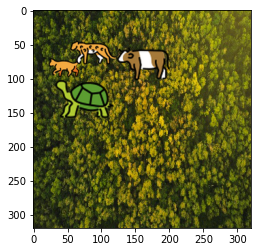

In [234]:
image, class_ids, bboxes = create_example()
# plt.xlabel(size)
plt.imshow(image)

In [235]:
class_ids, bboxes

([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0.098437501375, 0.31328124862499995, 0.369140626375, 0.49804687603125003],
  [0.06979166725, 0.20277777700000002, 0.22777777700000001, 0.30729166725],
  [0.165625, 0.1366319449375, 0.3813368050625, 0.25065104240625],
  [0.381423612375, 0.16879340309375, 0.62630208428125, 0.322829862375]])

In [240]:
# plot bboxes around object for confirmation of proper synthetic image is generated

def plot_bounding_box(image, gt_bbox, norm=False):
    # print(gt_bbox)
    if norm:
        image *= 255
        image = image.astype('uint8')

    try:
        draw = ImageDraw.Draw(image)
    except:
        image = Image.fromarray(image)
        draw = ImageDraw.Draw(image)
        
    for i in range(len(gt_bbox)):
        xmin, ymin, xmax, ymax = gt_bbox[i]
        xmin *= 320
        xmax *= 320
        ymin *= 320
        ymax *= 320

        draw.rectangle((xmin, ymin, xmax, ymax), outline='blue', width=1)
    return image

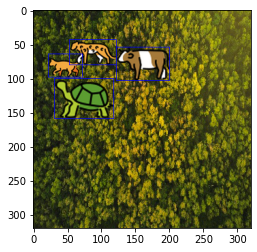

In [241]:

image = plot_bounding_box(image, gt_bbox=bboxes)
plt.imshow(image)
plt.show()

In [42]:
"""
Generates data of given batch size and number of objects
This is the generator function used for training the model with
synthetic data
"""
def data_generator(batch_size=16, nObjects=4):
    while True:
        x_batch = np.zeros((batch_size, 320, 320, 3))
        
        bbox_batch = np.zeros((batch_size, nObjects, 4))
        y_batch = np.zeros((batch_size, nObjects, 16))

        for i in range(0, batch_size):
            image, class_ids, bboxes = create_example(nObjects)
            
            x_batch[i] = np.array(image)/255.
            y_batch[i, :len(class_ids)] = np.array(class_ids)
            # print(np.array(bboxes).shape)
            bbox_batch[i, :len(class_ids)] = np.array(bboxes)
            labels = np.concatenate((bbox_batch, y_batch), axis=2)
        yield {'image': x_batch}, labels


In [43]:
example, label = next(data_generator(6))
x = example['image']
print('image_shape: ', x.shape) # image of shape 320 X 320 X 3
print('label_shape: ', label.shape) # 16 classes and 4 bounding boxes

image_shape:  (6, 320, 320, 3)
label_shape:  (6, 4, 20)


In [44]:
print('bbox_shape: ', label[:, :, :4].shape) # batch_size * nObjects * 4
label[:, :, :4]

bbox_shape:  (6, 4, 4)


array([[[0.21302083, 0.3359375 , 0.42447917, 0.51822917],
        [0.53893229, 0.76653646, 0.70282118, 0.87921007],
        [0.5515625 , 0.40833333, 0.8484375 , 0.68046875],
        [0.64166667, 0.34739583, 0.85494792, 0.49296875]],

       [[0.47708333, 0.76666667, 0.71041667, 0.9234375 ],
        [0.43732639, 0.13107639, 0.54800347, 0.24392361],
        [0.47413195, 0.3328993 , 0.80499132, 0.55872396],
        [0.8359375 , 0.04375   , 0.9765625 , 0.17265625]],

       [[0.12864583, 0.5109375 , 0.51458333, 0.84270834],
        [0.16757813, 0.71223958, 0.41302083, 0.87460938],
        [0.63333333, 0.61840278, 0.74166667, 0.75381944],
        [0.38975695, 0.31128472, 0.67586805, 0.50351563]],

       [[0.4875    , 0.36527778, 0.80347222, 0.53229167],
        [0.171875  , 0.54930556, 0.36631944, 0.65208333],
        [0.17395833, 0.07994792, 0.43958333, 0.31015625],
        [0.56701389, 0.04861111, 0.78576389, 0.19791667]],

       [[0.64166667, 0.25486111, 0.86736111, 0.40416667],
      

<h2><b> Model Architecture

In [264]:
# """
# Old Model Architecture
# -------------------

# 5 class heads of shapes:

# 20 x 20 x 64, 
# 10 x 10 x 64, 
# 5 x 5 x 64,
# 3 x 3 x 64,
# 1 x 1 x 64
# -----------
# Total : 535 X 64

# This 64 output channel of each head will be rehaped to 4 X 16
#  [4 for each anchor box and 16 for classes]
# and then stacked to get final class output shape of (2140 X 16)


# 5 box heads of shapes:

# 20 x 20 x 16, 
# 10 x 10 x 16, 
# 5 x 5 x 16,
# 3 x 3 x 16,
# 1 x 1 x 16
# -----------
# Total : 535 X 16

# This 16 channels will be rehaped to a single channel i.e 4 anchors X 4 boxes stacked atop 
# each other, so the total output shape will be (8560).

# It will next be reshaped to desired 2140 X 4 format and concatenated with 2140 X 16
# class output head and that will be our final output shape from the model which is:

#   2140 X 20 where first 4 colums are bboxes and last 16 colums are class probabilities (not in probabilistic form)

# """
# input_ = Input(shape=(320, 320, 3), name='image')


# conv2d_1 = Conv2D(16, 3, activation='relu', name='conv2d_1', padding='same')(input_)
# maxpool2d_1 = MaxPool2D(2, name='maxpool2d_1')(conv2d_1)
# batchnorm_1 = BatchNormalization(name='batchnorm_1')(maxpool2d_1)


# conv2d_2 = Conv2D(32, 3, activation='relu', name='conv2d_2', padding='same')(batchnorm_1)
# maxpool2d_2 = MaxPool2D(2, name='maxpool2d_2')(conv2d_2)
# batchnorm_2 = BatchNormalization(name='batchnorm_2')(maxpool2d_2)


# conv2d_3 = Conv2D(64, 3, activation='relu', name='conv2d_3', padding='same')(batchnorm_2)
# maxpool2d_3 = MaxPool2D(2, name='maxpool2d_3')(conv2d_3)
# batchnorm_3 = BatchNormalization(name='batchnorm_3')(maxpool2d_3)


# conv2d_4 = Conv2D(128, 3, activation='relu', name='conv2d_4', padding='same')(batchnorm_3)
# maxpool2d_4 = MaxPool2D(2, name='maxpool2d_4')(conv2d_4) # 20x20x128
# batchnorm_4 = BatchNormalization(name='batchnorm_4')(maxpool2d_4)


# conv2d_5 = Conv2D(256, 3, activation='relu', name='conv2d_5', padding='same')(batchnorm_4)
# maxpool2d_5 = MaxPool2D(2, name='maxpool2d_5')(conv2d_5) # 10x10x128
# batchnorm_5 = BatchNormalization(name='batchnorm_5')(maxpool2d_5)


# conv2d_6 = Conv2D(256, 3, activation='relu', name='conv2d_6', padding='same')(batchnorm_5)
# maxpool2d_6 = MaxPool2D(2, name='maxpool2d_6')(conv2d_6) # 5x5x128 output
# batchnorm_6 = BatchNormalization(name='batchnorm_6')(maxpool2d_6)
  
    
# conv2d_7 = Conv2D(256, 3, activation='relu', name='conv2d_7')(batchnorm_6) # 3x3x128 output
# conv2d_8 = Conv2D(512, 3, activation='relu', name='conv2d_8')(conv2d_7) # 1x1x256 output
    

# class_20x20 = Conv2D(64, 3, name='class_20x20', activation='linear', padding='same')(maxpool2d_4)
# class_20x20_reshape = Reshape((-1, 16), name='class_20x20_reshape')(class_20x20)
# # class_20x20_reshape_sm = tf.keras.layers.Softmax(name='class_20x20_reshape_softmax')(class_20x20_reshape)
# box_20x20 = Conv2D(16, 3, name='box_20x20', padding='same')(maxpool2d_4)
# box_20x20_reshape = Flatten(name='box_20x20_reshape')(box_20x20)


# class_10x10 = Conv2D(64, 3, name='class_10x10', activation='linear', padding='same')(maxpool2d_5)
# class_10x10_reshape = Reshape((-1, 16), name='class_10x10_reshape')(class_10x10)
# # class_10x10_reshape_sm = tf.keras.layers.Softmax(name='class_10x10_reshape_softmax')(class_10x10_reshape)
# box_10x10 = Conv2D(16, 3, name='box_10x10', padding='same')(maxpool2d_5)
# box_10x10_reshape = Flatten(name='box_10x10_reshape')(box_10x10)


# class_5x5 = Conv2D(64, 3, name='class_5x5', activation='linear', padding='same')(maxpool2d_6)
# class_5x5_reshape = Reshape((-1, 16), name='class_5x5_reshape')(class_5x5)
# # class_5x5_reshape_sm = tf.keras.layers.Softmax(name='class_5x5_reshape_softmax')(class_5x5_reshape)
# box_5x5 = Conv2D(16, 3, name='box_5x5', padding='same')(maxpool2d_6)
# box_5x5_reshape = Flatten(name='box_5x5_reshape')(box_5x5)


# class_3x3 = Conv2D(64, 3, name='class_3x3', activation='linear', padding='same')(conv2d_7)
# class_3x3_reshape = Reshape((-1, 16), name='class_3x3_reshape')(class_3x3)
# # class_3x3_reshape_sm = tf.keras.layers.Softmax(name='class_3x3_reshape_softmax')(class_3x3_reshape)
# box_3x3 = Conv2D(16, 3, name='box_3x3', padding='same')(conv2d_7)
# box_3x3_reshape = Flatten(name='box_3x3_reshape')(box_3x3)


# class_1x1 = Conv2D(64, 3, name='class_1x1', activation='linear', padding='same')(conv2d_8)
# class_1x1_reshape = Reshape((-1, 16), name='class_1x1_reshape')(class_1x1)
# # class_1x1_reshape_sm = tf.keras.layers.Softmax(name='class_1x1_reshape_softmax')(class_1x1_reshape)
# box_1x1 = Conv2D(16, 3, name='box_1x1', padding='same')(conv2d_8)
# box_1x1_reshape = Flatten(name='box_1x1_reshape')(box_1x1)


    
  
# # class_out = Concatenate(axis=1, name='class_out')([class_20x20_reshape_sm, class_10x10_reshape_sm, class_5x5_reshape_sm, class_3x3_reshape_sm, class_1x1_reshape_sm])

# class_out = Concatenate(axis=1, name='class_out')([class_20x20_reshape, class_10x10_reshape, class_5x5_reshape, class_3x3_reshape, class_1x1_reshape])
# box_out = Concatenate(axis=1, name='box_out')([box_20x20_reshape, box_10x10_reshape, box_5x5_reshape, box_3x3_reshape, box_1x1_reshape])
    
# box_out_reshape = Reshape((-1, 4), name='box_out_reshape')(box_out)
# final_output = Concatenate(axis=2, name='final_output')([box_out_reshape, class_out])
# # print(bbox_out.shape)
# # x = Flatten()(conv2d_8)
# # x = Dense(256, activation='relu')(x)
# # class_out = Dense(15, activation='softmax', name='class_out')(x)
# # box_out = Dense(4, name='box_out')(x)

# # model = tf.keras.models.Model(input_, [class_out, box_out])
# model = tf.keras.models.Model(input_, final_output)
# model.summary()

In [242]:
"""
Model Architecture
-------------------

5 class heads of shapes:

20 x 20 x 64, 
10 x 10 x 64, 
5 x 5 x 64,
3 x 3 x 64,
1 x 1 x 64
-----------
Total : 535 X 64

This 64 output channel of each head will be rehaped to 4 X 16
 [4 for each anchor box and 16 for classes]
and then stacked to get final class output shape of (2140 X 16)


5 box heads of shapes:

20 x 20 x 16, 
10 x 10 x 16, 
5 x 5 x 16,
3 x 3 x 16,
1 x 1 x 16
-----------
Total : 535 X 16

This 16 channels will be rehaped to a 4 channel i.e 4 anchors X 4 boxes anchors being stacked atop 
each other, so the total output shape will be (2140 X 4).



  2140 X 20 where first 4 colums are bboxes and last 16 colums are class probabilities (not in probabilistic form)

"""
input_ = Input(shape=(320, 320, 3), name='image')


conv2d_1 = Conv2D(16, 3, activation='relu', name='conv2d_1', padding='same')(input_)
maxpool2d_1 = MaxPool2D(2, name='maxpool2d_1')(conv2d_1)
batchnorm_1 = BatchNormalization(name='batchnorm_1')(maxpool2d_1)


conv2d_2 = Conv2D(32, 3, activation='relu', name='conv2d_2', padding='same')(batchnorm_1)
maxpool2d_2 = MaxPool2D(2, name='maxpool2d_2')(conv2d_2)
batchnorm_2 = BatchNormalization(name='batchnorm_2')(maxpool2d_2)


conv2d_3 = Conv2D(64, 3, activation='relu', name='conv2d_3', padding='same')(batchnorm_2)
maxpool2d_3 = MaxPool2D(2, name='maxpool2d_3')(conv2d_3)
batchnorm_3 = BatchNormalization(name='batchnorm_3')(maxpool2d_3)


conv2d_4 = Conv2D(128, 3, activation='relu', name='conv2d_4', padding='same')(batchnorm_3)
maxpool2d_4 = MaxPool2D(2, name='maxpool2d_4')(conv2d_4) # 20x20x128
batchnorm_4 = BatchNormalization(name='batchnorm_4')(maxpool2d_4)


conv2d_5 = Conv2D(256, 3, activation='relu', name='conv2d_5', padding='same')(batchnorm_4)
maxpool2d_5 = MaxPool2D(2, name='maxpool2d_5')(conv2d_5) # 10x10x128
batchnorm_5 = BatchNormalization(name='batchnorm_5')(maxpool2d_5)


conv2d_6 = Conv2D(256, 3, activation='relu', name='conv2d_6', padding='same')(batchnorm_5)
maxpool2d_6 = MaxPool2D(2, name='maxpool2d_6')(conv2d_6) # 5x5x128 output
batchnorm_6 = BatchNormalization(name='batchnorm_6')(maxpool2d_6)
  
    
conv2d_7 = Conv2D(256, 3, activation='relu', name='conv2d_7')(batchnorm_6) # 3x3x128 output
conv2d_8 = Conv2D(512, 3, activation='relu', name='conv2d_8')(conv2d_7) # 1x1x256 output
    

class_20x20 = Conv2D(64, 3, name='class_20x20', activation='linear', padding='same')(maxpool2d_4)
class_20x20_reshape = Reshape((-1, 16), name='class_20x20_reshape')(class_20x20)
# class_20x20_reshape_sm = tf.keras.layers.Softmax(name='class_20x20_reshape_softmax')(class_20x20_reshape)
box_20x20 = Conv2D(16, 3, name='box_20x20', padding='same')(maxpool2d_4)
box_20x20_reshape = Reshape((-1, 4), name='box_20x20_reshape')(box_20x20)


class_10x10 = Conv2D(64, 3, name='class_10x10', activation='linear', padding='same')(maxpool2d_5)
class_10x10_reshape = Reshape((-1, 16), name='class_10x10_reshape')(class_10x10)
# class_10x10_reshape_sm = tf.keras.layers.Softmax(name='class_10x10_reshape_softmax')(class_10x10_reshape)
box_10x10 = Conv2D(16, 3, name='box_10x10', padding='same')(maxpool2d_5)
box_10x10_reshape = Reshape((-1, 4), name='box_10x10_reshape')(box_10x10)


class_5x5 = Conv2D(64, 3, name='class_5x5', activation='linear', padding='same')(maxpool2d_6)
class_5x5_reshape = Reshape((-1, 16), name='class_5x5_reshape')(class_5x5)
# class_5x5_reshape_sm = tf.keras.layers.Softmax(name='class_5x5_reshape_softmax')(class_5x5_reshape)
box_5x5 = Conv2D(16, 3, name='box_5x5', padding='same')(maxpool2d_6)
box_5x5_reshape = Reshape((-1, 4), name='box_5x5_reshape')(box_5x5)


class_3x3 = Conv2D(64, 3, name='class_3x3', activation='linear', padding='same')(conv2d_7)
class_3x3_reshape = Reshape((-1, 16), name='class_3x3_reshape')(class_3x3)
# class_3x3_reshape_sm = tf.keras.layers.Softmax(name='class_3x3_reshape_softmax')(class_3x3_reshape)
box_3x3 = Conv2D(16, 3, name='box_3x3', padding='same')(conv2d_7)
box_3x3_reshape = Reshape((-1, 4), name='box_3x3_reshape')(box_3x3)


class_1x1 = Conv2D(64, 3, name='class_1x1', activation='linear', padding='same')(conv2d_8)
class_1x1_reshape = Reshape((-1, 16), name='class_1x1_reshape')(class_1x1)
# class_1x1_reshape_sm = tf.keras.layers.Softmax(name='class_1x1_reshape_softmax')(class_1x1_reshape)
box_1x1 = Conv2D(16, 3, name='box_1x1', padding='same')(conv2d_8)
box_1x1_reshape = Reshape((-1, 4), name='box_1x1_reshape')(box_1x1)


    
  
# class_out = Concatenate(axis=1, name='class_out')([class_20x20_reshape_sm, class_10x10_reshape_sm, class_5x5_reshape_sm, class_3x3_reshape_sm, class_1x1_reshape_sm])

class_out = Concatenate(axis=1, name='class_out')([class_20x20_reshape, class_10x10_reshape, class_5x5_reshape, class_3x3_reshape, class_1x1_reshape])
box_out = Concatenate(axis=1, name='box_out')([box_20x20_reshape, box_10x10_reshape, box_5x5_reshape, box_3x3_reshape, box_1x1_reshape])
    
# box_out_reshape = Reshape((-1, 4), name='box_out_reshape')(box_out)
final_output = Concatenate(axis=2, name='final_output')([box_out, class_out])


# model = tf.keras.models.Model(input_, [class_out, box_out])
model = tf.keras.models.Model(input_, final_output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 320, 320, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 maxpool2d_1 (MaxPooling2D)     (None, 160, 160, 16  0           ['conv2d_1[0][0]']               
                                )                                                           

In [243]:
# load pre trained weights if you want
model.load_weights('/content/drive/MyDrive/customOD/weights281022/epoch_latest.model')

In [49]:
batch_size = 1
example, label = next(data_generator(batch_size))
x = example['image']

pred = model.predict(x)
print('predicted: ', pred.shape)


bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, label[:, :, 4:], label[:, :, :4])
print('generated_labels_wrt_anchors: ', bbox_labels.shape, bbox_masks.shape, cls_labels.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 8s 8s/step
predicted:  (1, 2140, 20)
generated_labels_wrt_anchors:  (1, 8560) (1, 8560) (1, 2140, 16)


<h2><b>Inferencing functions

In [94]:
"""
One of the most important function for post processing the multiple same class
overlapping output boxes. Check comments inside function for details
"""
def non_max_supression(sortedArr):
    final_list = np.array([sortedArr[0]])
    sortedArr = sortedArr[1:]
    for element in sortedArr:

        # if same class is already present in target list
        if element[0] in final_list[:, 0]:

            # get the indexes of all present same elements
            indexes_present = np.where(final_list[:, 0]==element[0])[0]

            # calclulate iou for all present same class element
            # print('indexes_present: ', indexes_present)
            # print('shapes: ', element[2:].reshape(1, 4).shape, final_list[indexes_present, 2:].shape)
            ious = box_iou(element[2:].reshape(1, 4), final_list[indexes_present, 2:])

            # get indexes of all ious above 0.5
            # print('ious: ', ious)
            ious_indexes = np.where(ious[0, :] > 0.5)[0]

            # if there is no element present which alraedy has an iou of 
            # over 0.5 with current element then push it
            # print('ious_indexes: ', ious_indexes)
            if ious_indexes.size == 0:
                final_list = np.vstack([final_list, element])
        else:
            final_list = np.vstack([final_list, element])
            
    return final_list

In [95]:
# generate random image and perform inference on it with visual outputs

def test_predictions():
    
    n_objects = 4
    image, labels = next(data_generator(1, n_objects))
    predicted = model.predict(image)
    
    predicted_cls, predicted_box = predicted[:, :, 4:], predicted[:, :, :4]
    bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, labels[:, :, 4:], labels[:, :, :4])
    
    inversed_pred_boxes = offset_inverse(anchors[0], predicted_box[0])
    
    predicted_cls = tf.nn.softmax(predicted_cls[0])
    class_ids = np.argmax(predicted_cls, axis=1)
    class_prob = []

    for idx, cls_id in enumerate(class_ids):
        class_prob.append([cls_id, predicted_cls[idx][cls_id]])

    class_prob = np.array(class_prob)
    
    combined = np.concatenate([class_prob, inversed_pred_boxes], axis=1)
    # print('shape: ', combined.shape)
    indexes = np.where((combined[:, 0] < 15) & (combined[:, 1] > 0.1))
    combined = combined[indexes].astype(np.float16)
    sortedArr = combined[combined[:,1].argsort()][::-1]
    if sortedArr.shape[0] == 0:
        return  draw_boxes(sortedArr, image['image'][0], display_label=True)
    detetctions = non_max_supression(sortedArr)
    # for x in detetctions[:, 0]:
    #     print(animals[x]['name'])
    painted_img = draw_boxes(detetctions, image['image'][0], display_label=True)
    
    return painted_img
    

In [292]:
def draw_boxes(boxes, image, display_label=True):
    
    cv2.imwrite('test.png', image * 255)
    image = cv2.imread('test.png')
    
    size = image.shape[0]
    boxes = boxes * size
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    # if the values are ground truth
    if(boxes.shape[1] == 5):
        for box in boxes:
            draw.rectangle((box[1], box[2], box[3], box[4]), outline='red', width=1)
            if display_label:
                text = animals[box[0]/size]['name']
                draw.rectangle((box[1], box[2], box[1] + len(text)*6.5, box[2]+10), fill='red', width=1)
                draw.text((box[1]+2, box[2]-2), text, 'white', font=font)

    # if the values are predicted
    else:
        for box in boxes:
            draw.rectangle((box[2], box[3], box[4], box[5]), outline='blue', width=1)
            if display_label:
                text = animals[box[0]/size]['name'] + ': ' + str(box[1]/size * 1000 // 1 / 10)
                draw.rectangle((box[2], box[3], box[2] + len(text)*5.5, box[3]+10), fill='blue', width=1)
                draw.text((box[2]+2, box[3]-2), text, 'white', font=font)
            
    return image      

1/1 [==============================] - 0s 33ms/step


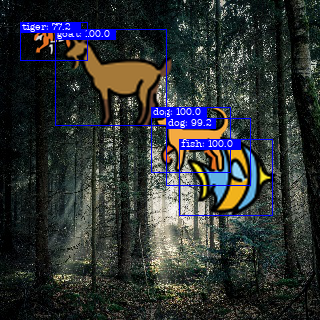

In [97]:
test_predictions()

In [98]:
def test(model):
    plt.figure(figsize=(32, 8))
    for i in range(0, 4):
        plt.subplot(1, 4, i+1)
        plt.imshow(test_predictions())
    plt.show()

<h2><b> Training helper functions and TRAINING..

In [99]:
# callback function for Image inferencing during training
class testImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

In [251]:
# callback function for saving checkpoints during training
class saveCheckpoint(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights('/content/drive/MyDrive/customOD/weights291022/epoch_latest.model')

1/1 [==============================] - 0s 35ms/step


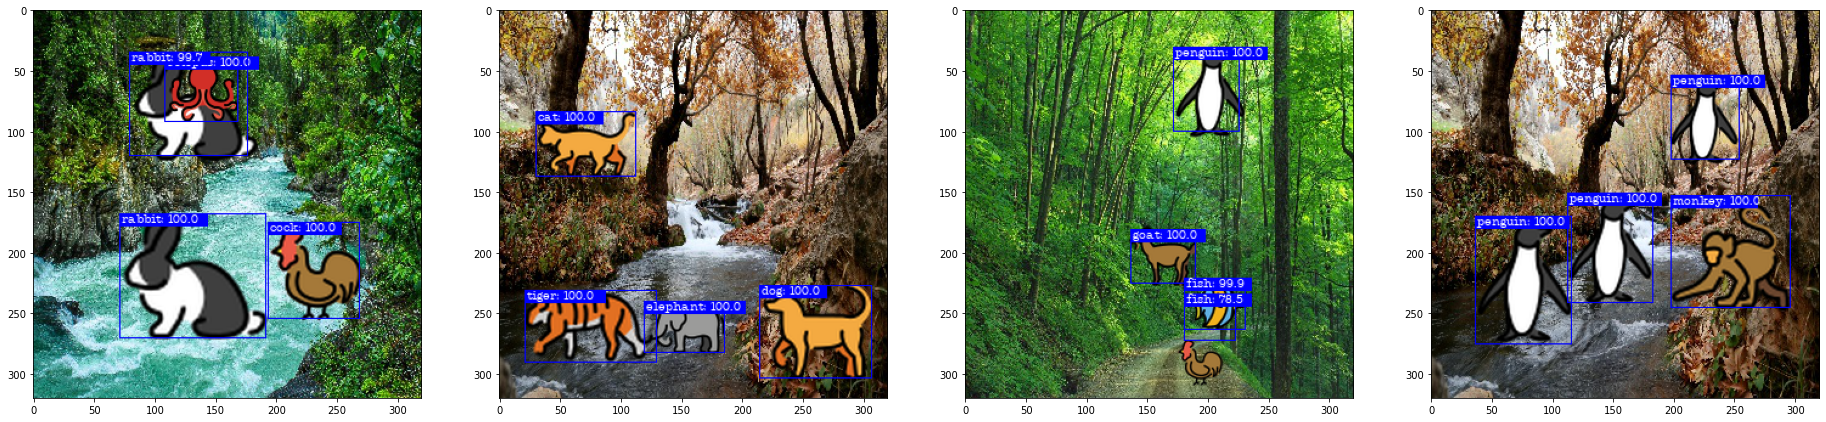

In [254]:
test(model)

In [244]:
"""
while calculating box accuracy if we consider all 2140 outputs then most of them has zero values in both predicted 
and ground truth boxes so it will lead to very high box accuracy even when thats not the case
"""

def calc_box_accuracy(pred_class, pred_box, bbox_labels):
    batchwise_loss = []
    batch_size = pred_class.shape[0]
    for i in range(batch_size):
        indexes = tf.where(tf.argmax(pred_class[i, :, :], axis=1) != 15)
        if(indexes.shape[0] == 0):
            continue
        box_indexes = tf.convert_to_tensor([indexes*4, indexes*4+1, indexes*4+2, indexes*4+3]).reshape(-1)
        batchwise_loss.append(tf.abs(bbox_labels[i, box_indexes] - pred_box[i, box_indexes]).numpy().sum() / box_indexes.shape[0])
    
    if len(batchwise_loss) == 0:
        return 1.9
    return np.array(batchwise_loss).astype(np.float16).mean()

In [245]:
"""
Custom loss function for:
Calculating and Logging class, box losses and accuracy metrics

Both are being done at same place to save resources calculating same thing in 
multiple places
"""

accuracy = tf.keras.metrics.CategoricalAccuracy()

box_loss_log = []
class_loss_log = []
box_accuracy_log = []
class_accuracy_log = []

def custom_loss(label, pred):
    
    # extract the predicted and ground truth boxes and classes
    label_box = label[:, :, :4]
    label_class = label[:, :, 4:]
    
    batch_size = pred.shape[0]
    
    pred_box = pred[:, :, :4].reshape(-1, 8560)
    pred_class = pred[:, :, 4:]
    
    
    # get the ground truth lables dimensions changed to prediction dimensions by using anchors
    bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, label_class, label_box)

    # calculate losses
    bbox_loss = tf.keras.metrics.mean_squared_error(bbox_labels * bbox_masks, pred_box * bbox_masks).mean()

    """
    For class loss the classes are not already softmaxed from model so they are passed
    through "softmax_cross_entropy_with_logits" which calculates the softmax inplace and calculates
    loss using it in accurate manner

    For class loss all the 2140 predictions are used for loss calculation because any class which is background 
    and not classified as background needs to be punished and vice-versa

    while in the case of box loss only the masked boxes (masked boxes are those anchor boxes which has a probability that
    it contains an object) are considered for loss calculation
    because whatever value the unwanted predicted boxes have doesnt matters here and considering them will
    incur unwanted loss addition in training
    """
    class_loss = tf.nn.softmax_cross_entropy_with_logits(cls_labels, pred_class).mean()
    
    # calculate accuracies
    accuracy.update_state(cls_labels, pred_class)
    box_accuracy = 1 - calc_box_accuracy(pred_class, pred_box, bbox_labels)
    
    # log the metrices
    box_loss_log.append(bbox_loss.numpy())
    class_loss_log.append(class_loss.numpy())
    box_accuracy_log.append(box_accuracy)
    class_accuracy_log.append(accuracy.result().numpy())
    

    # print metrices
    print('\n\nbox_loss: ', bbox_loss.numpy())
    print('class_loss: ', class_loss.numpy())
    
    print('class_accuracy: ', accuracy.result().numpy())
    print('bbox_accuracy: ', box_accuracy)
    
    # return total loss for proper model convergence
    return class_loss + bbox_loss
    
    

In [246]:
""" For Experimnets """
lab_cls = np.zeros((4, 2140, 16))
for k in range(4):
    for i in range(2140):
        # if(i%4==0):
        #     continue
        lab_cls[k, i, np.random.randint(0, 16)] = 1

# lab_cls
prd_cls = np.random.randint(-10, 15, [4, 2140, 16])/10
prd_cls = tf.nn.softmax(prd_cls, axis=2)

# for i in range(4):
#     # print(tf.argmax(lab_cls[i, :, :], axis=1) == 15)
#     indexes = tf.where(tf.argmax(lab_cls[i, :, :], axis=1) == 15)
#     print(indexes)
    # print(tf.convert_to_tensor([indexes*4, indexes*4+1, indexes*4+2, indexes*4+3]).reshape(-1))
# tf.stack([indexes, indexes[:, 1] * 4], axis=0)

# print(prd_cls[0, :5, :])
# print(lab_cls[0, :5, :])
# print(tf.nn.softmax(prd_cls[0, :1, :]).numpy().sum())

# # m = tf.keras.metrics.Accuracy()
# # m.update_state([1.00, 0.00, 0.00, 0.00], [0.99, 0.05, 0.004, 0.001])
# # m.result().numpy()

# # tf.keras.metrics.mean_absolute_error([1, 0, 0, 0], [0.99, 0.005, 0.004, 0.001])
# m = tf.keras.metrics.CategoricalAccuracy()
# m.update_state(lab_cls, prd_cls)
# m.result().numpy()

# 1 - tf.keras.metrics.mean_absolute_error(lab_cls[0, :5, :], prd_cls[0, :5, :]).mean().numpy()

In [247]:
"""
Only one custom loss is used to calculate loss, metrics
displaying them and storing them in list. ALL these tasks are handled by a single
function "custom_loss"
"""
keras.losses.custom_loss = custom_loss
model.compile(
    loss = 'custom_loss',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
)

In [248]:
def lr_schedule(epoch, lr):
    if (epoch+1) % 5 == 0:
        lr = lr*0.8
    return max(lr, 0.0000003)

In [ ]:
"""
Train the model with callbacks for periodically saving checkpoints,
showing outputs at the end of each epoch
"""

history = model.fit(
    data_generator(32),
    epochs = 50,
    steps_per_epoch = 100,
    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        saveCheckpoint(),
        testImages()
        
    ]
)

In [ ]:
# all the losses and metrics below can be accessed and plotted as desired
np.array(class_loss_log)
np.array(box_loss_log)
np.array(box_accuracy_log)
np.array(class_accuracy_log)

In [ ]:
"""
Save the model if you wish to...
"""
# %mkdir saved_model_back
# model.save_weights('saved_model_back/epoch20.model')
# !zip -r 'saved_model_back.zip' 'saved_model_back'

  adding: saved_model_back/ (stored 0%)
  adding: saved_model_back/epoch20.model.data-00000-of-00001 (deflated 40%)
  adding: saved_model_back/checkpoint (deflated 41%)
  adding: saved_model_back/epoch20.model.index (deflated 77%)


<h2><b>Inside inference logic

How each line of inferencing works will be explained below.

In [278]:
# generate an image with n no. of objects and batch_size of 1 ( don't change the 
# batch size as the logic is written only for single batch)

n_objects = 6
image, labels = next(data_generator(1, n_objects))
predicted = model.predict(image) # perform prediction on the generated image


1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [279]:
"""The predicted object has a shape of 2140 rows and 20 columns.
first 4 columns are bounding boxes in format (xmin, ymin, xmax, ymax)
and the remaining 16 are class predictions
"""

print('predicted_shape: ', predicted.shape)
predicted_cls, predicted_box = predicted[:, :, 4:], predicted[:, :, :4] # spereate bbox and classes from prediction
bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, labels[:, :, 4:], labels[:, :, :4]) # seperate bbox and classes from ground truth

predicted_shape:  (1, 2140, 20)


In [280]:
# respective class ids with its bounding boxes

label_box = np.hstack([np.argmax(labels[:, :, 4:], axis=2).reshape(n_objects, 1), labels[0, :, :4]])
label_box

array([[ 4.        ,  0.17595486,  0.45720486,  0.48363715,  0.77092014],
       [12.        ,  0.1625    ,  0.77829861,  0.41467014,  0.91158854],
       [ 1.        ,  0.34856771,  0.6672743 ,  0.58836805,  0.82591146],
       [11.        ,  0.08190104,  0.25351563,  0.34166667,  0.47682292],
       [11.        ,  0.73802083,  0.6921875 ,  0.94583333,  0.87083333],
       [11.        ,  0.51419271,  0.10664063,  0.65520833,  0.22786458]])

In [281]:
# as we know the predictions are actually offsets of default anchors so 
# it needs to pass through offset_inverse to get back the required bbox values

inversed_pred_boxes = offset_inverse(anchors[0], predicted_box[0])
inversed_pred_boxes.shape

TensorShape([2140, 4])

In [282]:
# our model is not doing a softmax operation on predicted classes so a softmax is needed before 
# proceeding
predicted_cls = tf.nn.softmax(predicted_cls[0])

# get the predicted class of row i.e. the highest value index of each row
class_ids = np.argmax(predicted_cls, axis=1)

# create a pair of classes and respective probability score
class_prob = []
for idx, cls_id in enumerate(class_ids):
    class_prob.append([cls_id, predicted_cls[idx][cls_id]])

class_prob = np.array(class_prob)
print(class_prob.shape)

(2140, 2)


In [283]:
# join bboxes and class, score arrays together to get required 6 columned array
combined = np.concatenate([class_prob, inversed_pred_boxes], axis=1)
print('shape: ', combined.shape) # shape of combined class probabilities and predicted bounding boxes

# get indexes of rows where the predicted class is not background and the confidence
# is greater than 50% (can be any value of our choice)
indexes = np.where((combined[:, 0] < 15) & (combined[:, 1] > 0.5))
combined = combined[indexes].astype(np.float16)
combined # this is the array which contains all our required objects but overlapped with 
# multiple instances of same object

shape:  (2140, 6)


array([[11.     ,  0.848  ,  0.5044 ,  0.0973 ,  0.654  ,  0.2288 ],
       [11.     ,  0.992  ,  0.5093 ,  0.1101 ,  0.651  ,  0.2302 ],
       [11.     ,  0.995  ,  0.5195 ,  0.1183 ,  0.652  ,  0.2294 ],
       [11.     ,  0.792  ,  0.514  ,  0.1186 ,  0.653  ,  0.2279 ],
       [11.     ,  0.963  ,  0.5166 ,  0.1102 ,  0.6567 ,  0.2246 ],
       [11.     ,  0.5005 ,  0.5156 ,  0.1048 ,  0.645  ,  0.223  ],
       [11.     ,  0.927  ,  0.0721 ,  0.2502 ,  0.3384 ,  0.4768 ],
       [11.     ,  0.951  ,  0.08105,  0.2632 ,  0.3347 ,  0.4824 ],
       [11.     ,  0.9644 ,  0.0836 ,  0.2551 ,  0.3472 ,  0.4746 ],
       [11.     ,  1.     ,  0.0847 ,  0.2546 ,  0.355  ,  0.4785 ],
       [11.     ,  1.     ,  0.0901 ,  0.2534 ,  0.3533 ,  0.4763 ],
       [11.     ,  1.     ,  0.0951 ,  0.256  ,  0.3489 ,  0.4768 ],
       [11.     ,  0.996  ,  0.07776,  0.2522 ,  0.3474 ,  0.4775 ],
       [11.     ,  1.     ,  0.0787 ,  0.2496 ,  0.3442 ,  0.4739 ],
       [11.     ,  1.     ,  0.075

In [284]:
# same array sorted in descending order of score
sortedArr = combined[combined[:,1].argsort()][::-1]
sortedArr

array([[11.     ,  1.     ,  0.0847 ,  0.2546 ,  0.355  ,  0.4785 ],
       [11.     ,  1.     ,  0.0783 ,  0.2474 ,  0.3582 ,  0.4783 ],
       [ 4.     ,  1.     ,  0.1794 ,  0.4507 ,  0.4785 ,  0.7607 ],
       [ 4.     ,  1.     ,  0.1825 ,  0.452  ,  0.4868 ,  0.781  ],
       [11.     ,  1.     ,  0.0821 ,  0.2483 ,  0.3433 ,  0.473  ],
       [11.     ,  1.     ,  0.06976,  0.2563 ,  0.322  ,  0.4824 ],
       [ 1.     ,  1.     ,  0.354  ,  0.666  ,  0.6016 ,  0.824  ],
       [ 1.     ,  1.     ,  0.3506 ,  0.6675 ,  0.598  ,  0.8247 ],
       [ 4.     ,  1.     ,  0.1825 ,  0.474  ,  0.4778 ,  0.777  ],
       [ 4.     ,  1.     ,  0.1772 ,  0.4631 ,  0.479  ,  0.7773 ],
       [11.     ,  1.     ,  0.0901 ,  0.2534 ,  0.3533 ,  0.4763 ],
       [12.     ,  1.     ,  0.1714 ,  0.779  ,  0.4211 ,  0.9062 ],
       [11.     ,  1.     ,  0.0842 ,  0.2512 ,  0.3542 ,  0.476  ],
       [11.     ,  1.     ,  0.7383 ,  0.696  ,  0.9424 ,  0.873  ],
       [ 1.     ,  1.     ,  0.338

In [285]:
label_box.shape

(6, 5)

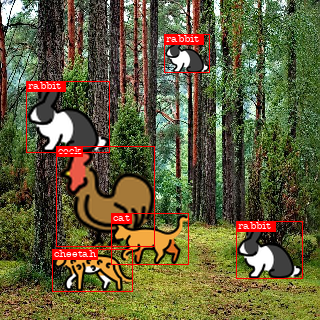

In [293]:
# drawing boxes on ground truth values
painted_img = draw_boxes(label_box, image['image'][0])
painted_img

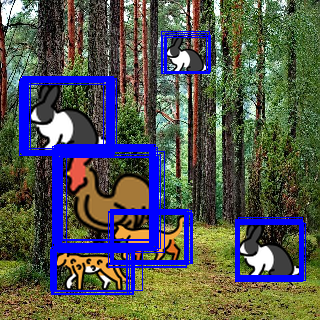

In [287]:
# drawing boxes over filtered predicted values, but the final output is still to come 
painted_img = draw_boxes(sortedArr, image['image'][0], display_label=False)
painted_img

In [288]:
# now the previous overlapping boxes goes for NMS for the final filtering and below
#  are the final results for this example image
detetctions = non_max_supression(sortedArr) # details of this functions is given as comments in it's definition please follow that
detetctions

array([[11.    ,  1.    ,  0.0847,  0.2546,  0.355 ,  0.4785],
       [ 4.    ,  1.    ,  0.1794,  0.4507,  0.4785,  0.7607],
       [ 1.    ,  1.    ,  0.354 ,  0.666 ,  0.6016,  0.824 ],
       [12.    ,  1.    ,  0.1714,  0.779 ,  0.4211,  0.9062],
       [11.    ,  1.    ,  0.7383,  0.696 ,  0.9424,  0.873 ],
       [11.    ,  0.995 ,  0.5195,  0.1183,  0.652 ,  0.2294]],
      dtype=float16)

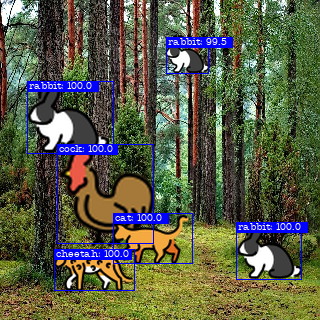

In [289]:
# THE FINAL OUTPUT

painted_img = draw_boxes(detetctions, image['image'][0], display_label=True)
painted_img

## Evaluating Model using mAP (mean Average Precision)

In [256]:
"""
Using library to calculate different mAP outputs using this wonderful repo.
Dont want to invest extra time for mAP calculation from scratch
"""
!git clone https://github.com/Cartucho/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [257]:
# remove dummy files provided in folder

%rm -rf /content/mAP/input/detection-results/*
%rm -rf /content/mAP/input/ground-truth/*
%rm -rf /content/mAP/input/images-optional/*

In [258]:
"""
Same logic as for inferencing with added blocks to save labels and predictions
as text files as required by the library to calculate mAP
"""

for i in range(100):
    print(i)
    
    n_objects = np.random.randint(1,6)
    image, labels = next(data_generator(1, n_objects))
    predicted = model.predict(image)
    predicted_cls, predicted_box = predicted[:, :, 4:], predicted[:, :, :4]
    bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, labels[:, :, 4:], labels[:, :, :4])

    label_box = np.hstack([np.argmax(labels[:, :, 4:], axis=2).reshape(n_objects, 1), labels[0, :, :4]])
    
    # write ground truth labels to txt file
    f = open('mAP/input/ground-truth/label_' + str(i+1) + '.txt','w+')
    for j in range(label_box.shape[0]):
        f.write(animals[label_box[j, 0]]['name'] + ' ' 
                + str(int(label_box[j, 1] * 320)) + ' ' 
                + str(int(label_box[j, 2] * 320)) + ' ' 
                + str(int(label_box[j, 3] * 320)) + ' ' 
                + str(int(label_box[j, 4] * 320)) + '\n')
    f.close()

    inversed_pred_boxes = offset_inverse(anchors[0], predicted_box[0])
    predicted_cls = tf.nn.softmax(predicted_cls[0])
    class_ids = np.argmax(predicted_cls, axis=1)
    class_prob = []

    for idx, cls_id in enumerate(class_ids):
        class_prob.append([cls_id, predicted_cls[idx][cls_id]])

    class_prob = np.array(class_prob)

    combined = np.concatenate([class_prob, inversed_pred_boxes], axis=1)
    indexes = np.where((combined[:, 0] < 15) & (combined[:, 1] > 0.5))
    combined = combined[indexes].astype(np.float16)

    # write predicted labels to txt file
    f = open('mAP/input/detection-results/label_' + str(i+1) + '.txt','w+')
    for j in range(combined.shape[0]):
        f.write(animals[combined[j, 0]]['name'] + ' ' 
                + str(combined[j, 1]) + ' ' 
                + str(int(combined[j, 2] * 320)) + ' ' 
                + str(int(combined[j, 3] * 320)) + ' ' 
                + str(int(combined[j, 4] * 320)) + ' ' 
                + str(int(combined[j, 5] * 320)) + '\n')
    

0
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 33ms/step
3
1/1 [==============================] - 0s 37ms/step
4
1/1 [==============================] - 0s 34ms/step
5
1/1 [==============================] - 0s 34ms/step
6
1/1 [==============================] - 0s 37ms/step
7
1/1 [==============================] - 0s 34ms/step
8
1/1 [==============================] - 0s 36ms/step
9
1/1 [==============================] - 0s 34ms/step
10
1/1 [==============================] - 0s 35ms/step
11
1/1 [==============================] - 0s 33ms/step
12
1/1 [==============================] - 0s 37ms/step
13
1/1 [==============================] - 0s 39ms/step
14
1/1 [==============================] - 0s 34ms/step
15
1/1 [==============================] - 0s 35ms/step
16
1/1 [==============================] - 0s 35ms/step
17
1/1 [==============================] - 0s 34ms/step
18
1/1 [============

In [259]:
!python mAP/main.py --no-animation

22.86% = cat AP 
20.39% = cheetah AP 
15.52% = cock AP 
19.84% = cow AP 
16.79% = dog AP 
21.57% = elephant AP 
20.71% = fish AP 
15.92% = goat AP 
20.42% = monkey AP 
15.08% = octopus AP 
19.48% = penguin AP 
15.57% = rabbit AP 
24.22% = rat AP 
20.50% = tiger AP 
26.07% = turtle AP 
mAP = 19.66%
Figure(640x480)


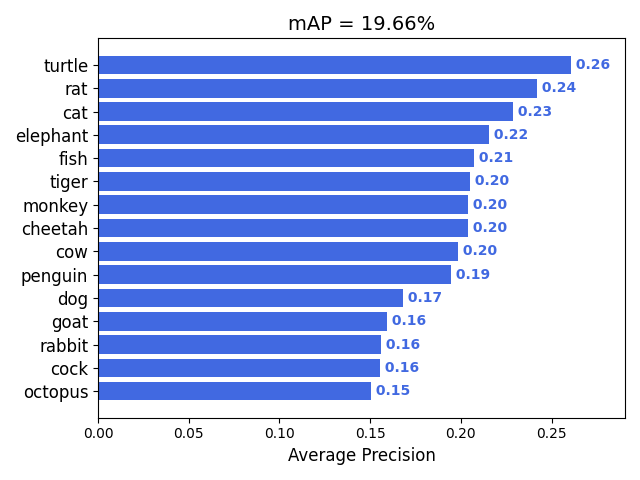

In [260]:
displayImage(filename='/content/mAP/output/mAP.png',width=700,height=500)

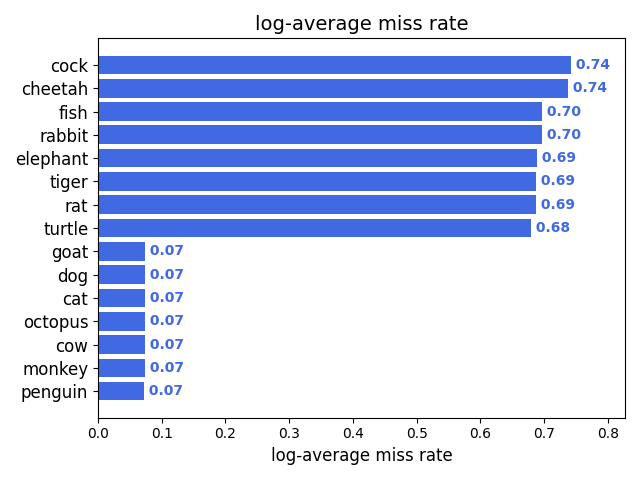

In [261]:
displayImage(filename='/content/mAP/output/lamr.png',width=700,height=500)

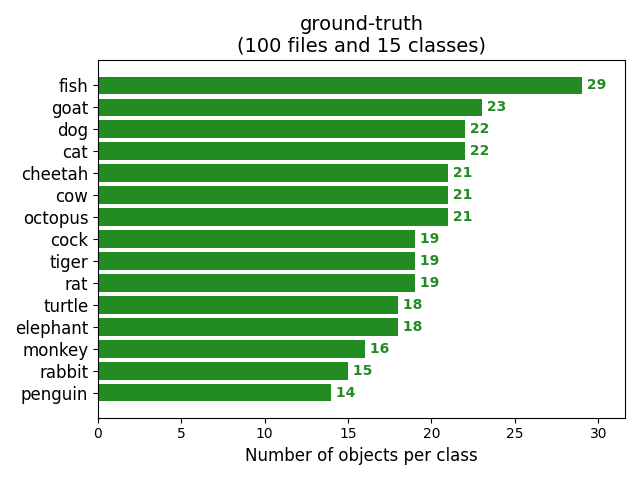

In [262]:
displayImage(filename='/content/mAP/output/ground-truth-info.png',width=700,height=500)

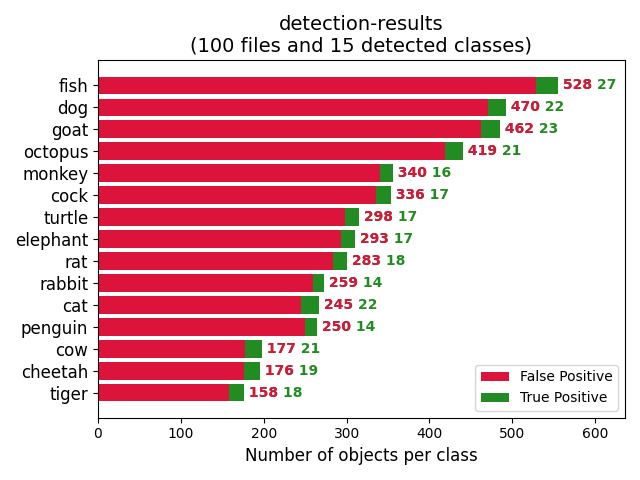

In [263]:
displayImage(filename='/content/mAP/output/detection-results-info.png',width=700,height=500)